# Topic Exploration

<h3>Objective:</h3>

Perform analysis and describe the following:

    - Top Overall Topics as a baseline comparisson
    - Top Topics associated to deleted emails
    - Top topics associated to Enron Chairman

Hypotheses:

    - What are the emails that got deleted? Is there any evidence of suspicious giding of accounting documents?
    - Do we find suspicious email / topics within Enron Chairman's mailbox?

Methodology:

    1. Manual analysis and data aggregation of clustered Data Frame to find Top topics with different filters (overall, deleted, and received by Enron Chairman)
    2. Use Topic dashboard to describe the topic, its trend and distribution
    3. Compare topics found in deleted and Enron chairman against overall. 
        - Are the emails of types that we expect to be regularly deleted? OR received/sent by an executive?


In [ ]:

import transformers
import pandas as pd
import numpy as np
import plotly.express as px
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

from sentence_transformers import SentenceTransformer

## Read Clustered Dataframe

In [2]:
df_clean_2001_pick = pd.read_pickle('..\data\df_clean_2001_roberta_pick.pkl.gz', compression='gzip')

df_clean_2001_pick.head(2)

subject date_short  \
0                 Yahoo! Newsletter, May 2001 2001-05-14   
1  Texas puts reliability rules through paces 2001-05-14   

                                      message_id  \
0  <12657912.1075855693014.JavaMail.evans@thyme>   
1   <6437131.1075855693092.JavaMail.evans@thyme>   

                      from_addr person_box    sub_mailbox sub_mailbox2  \
0  yahoo-delivers@yahoo-inc.com    Allen-P  all_documents                
1        ei_editor@ftenergy.com    Allen-P  all_documents                

                                          email_body  \
0  [IMAGE]\nYahoo! sent this email to you because...   
1  Dear Energy  Insight Subscribers.?If you canno...   

                                  cleaned_email_body  possible_accounting  \
0  [IMAGE] Yahoo! sent this email to you because ...             0.102435   
1  Dear Energy Insight Subscribers.?If you cannot...             0.212221   

   possible_hate_anger                                  embedding_roberta  \
0             0.182009  [-0.01384270191192627, 0.008414888754487038, 0...   
1             0.164912  [0.03549579530954361, 0.015364758670330048, 0....   

                           embedding_roberta_reduced  \
0  [3.196415662765503, 6.6560587882995605, 6.1493...   
1  [7.292938709259033, 4.749783992767334, 4.90643...   

   hdbscan_clusters_roberta  hdbscan_clusters_roberta_prob  \
0                      2449                       1.000000   
1                      2298                       0.541348   

   reduced_labels_dbscan_cut  reduced_labels_scipy_cut  kmeans_clusters  
0                        259                        56              348  
1                        259                        56              306

## Revisit Deletion in May/June and October-Dec 2001

- There where peaks in amounts of email deleted that happened in May-June and Oct-Dec of 2001
- This is the reason we want to zoom in deleted emails and find out if there are any irregularities 


In [3]:
df_clean_2001_pick['date_short_month']  = pd.to_datetime(df_clean_2001_pick['date_short']).dt.strftime('%b')


# Filter top mailbox
mailboxes=['inbox', 'deleted_items', 'sent','sent_items', 'all_documents', 'calendar', '_sent_mail', 'notes_inbox', 'discussion_threads']

df_clean_2001_pick_box = df_clean_2001_pick[df_clean_2001_pick['sub_mailbox'].isin(mailboxes)]


df_trend = df_clean_2001_pick_box.groupby(['date_short_month','sub_mailbox']).size().reset_index(name='email_count')

month_order = [
        'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
    ]

fig_line = px.bar(
        df_trend, 
        x='date_short_month', 
        y='email_count', 
        title='Total Email Count by Month',
        color='sub_mailbox',
        labels={'date_short_month': 'Month', 'email_count': 'Total Email Count'},
        category_orders={'date_short_month': month_order}

    )

fig_line.show()

## Top Topic Overall

In [5]:
cond1=df_clean_2001_pick_box.hdbscan_clusters_roberta >-1
cond_wordLen=len(df_clean_2001_pick_box.cleaned_email_body.str.split())> 5 # min words in email body


top_overall = df_clean_2001_pick_box[cond1 & cond_wordLen].groupby('hdbscan_clusters_roberta').size().reset_index(name='email_count')
top_overall.set_index('hdbscan_clusters_roberta',inplace=True)

# 1. Calculate the total number of emails across all clusters (excluding noise -1)
total_emails = top_overall['email_count'].sum()

# 2. Add a new column for the percentage share
# Divide the 'email_count' of each row by the total_emails
top_overall['share_percent'] = (top_overall['email_count'] / total_emails) * 100

# Optional: Format the percentage column to one decimal place for cleaner display
top_overall['share_percent'] = top_overall['share_percent']#.round(1).astype(str) + '%'
top_overall=top_overall.sort_values(by='email_count', ascending=False)
top_overall.head(5)#.shape


email_count  share_percent
hdbscan_clusters_roberta                            
5                                 959       0.799760
4670                              501       0.417810
3871                              465       0.387788
1122                              352       0.293551
483                               352       0.293551

## Top 5 topics overall from HDBSCAN Clusters

By using topic dashboard we got the following info to describe these clusters

1. Cluster 5 - Short FYI emails
2. Clutser 4670 - Asking for availabilty for a meeting
3. Cluster 3871 - Concerning Cost and Budget
4. Cluster 1122 - Casual Emails, personal news, gossips
5. Cluster 483 - Short FYI emails

| Cluster 5 | Cluster 4670 | Cluster 3871 | Cluster 1122 | Cluster 483 |
|---|---|---|---|---|
|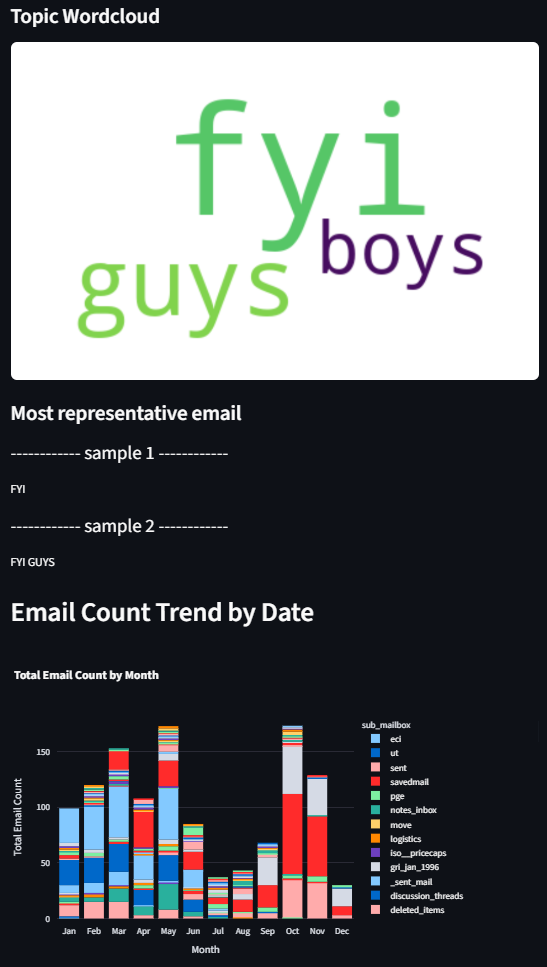|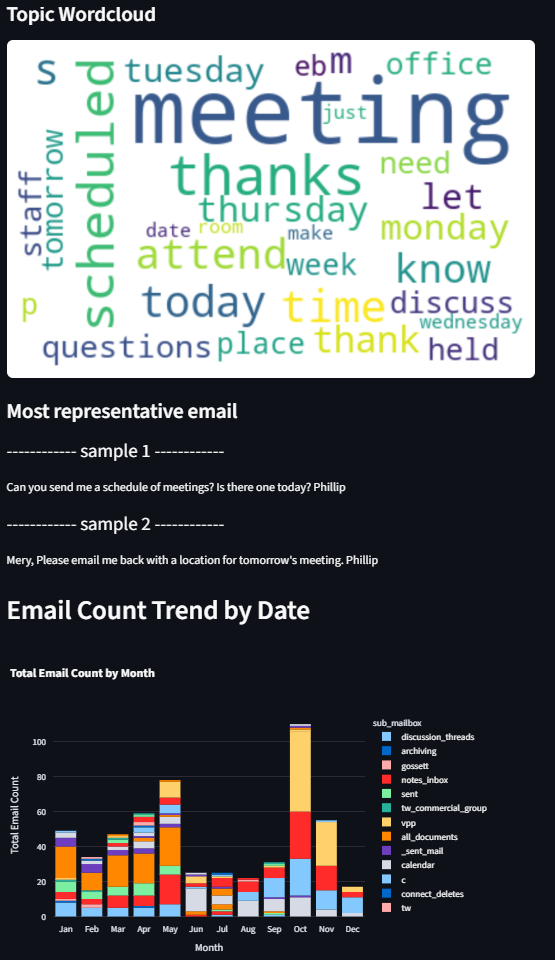|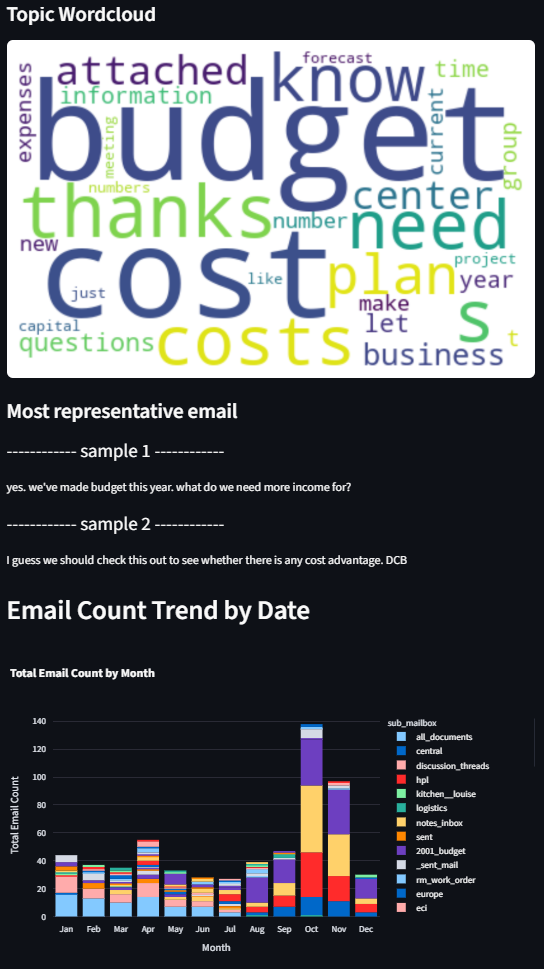|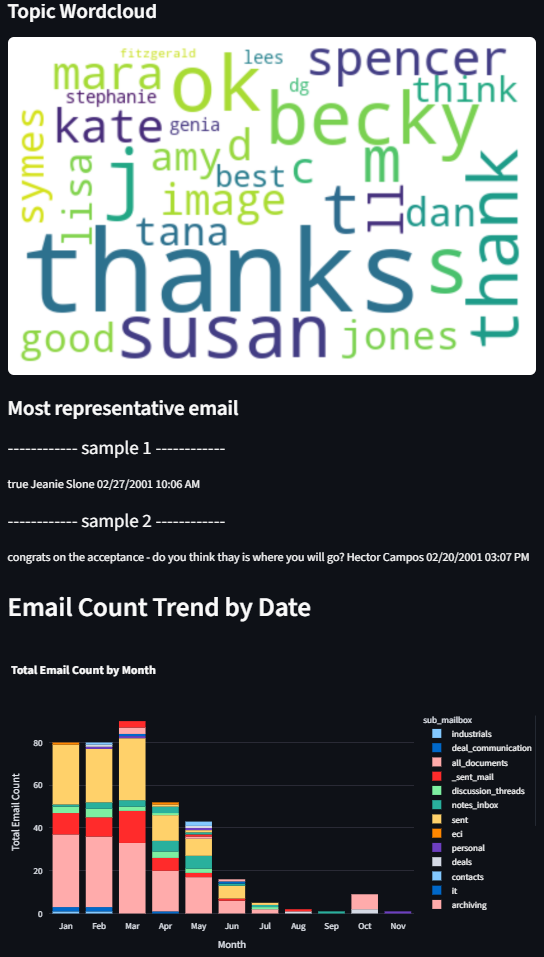|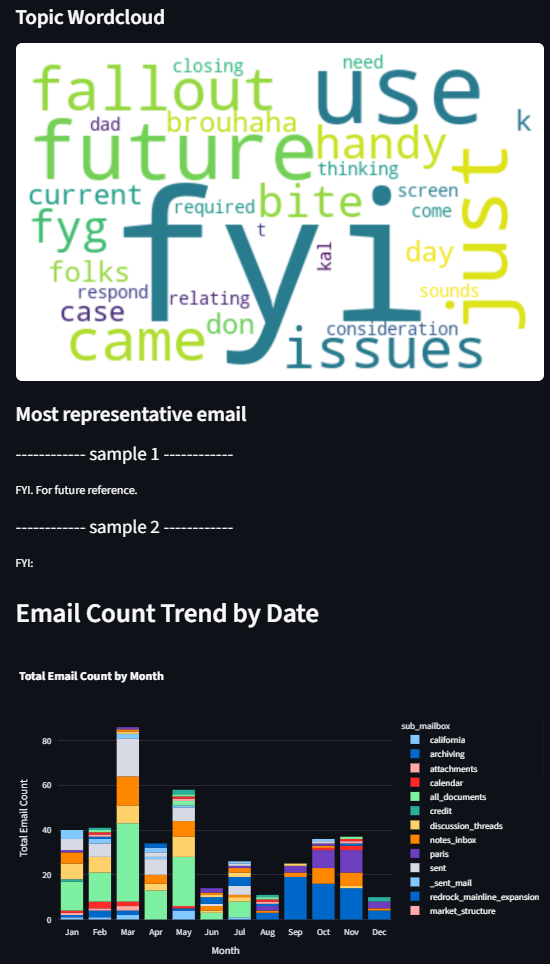|




## Top Topic Deleted Items

In [ ]:
cond1=df_clean_2001_pick_box.hdbscan_clusters_roberta >-1
cond2=df_clean_2001_pick_box.sub_mailbox=='deleted_items'


top_deleted = df_clean_2001_pick_box[cond1 & cond2 & cond_wordLen].groupby('hdbscan_clusters_roberta').size().reset_index(name='email_count_deleted')#.sort_values(by='email_count_deleted', ascending=False)#.head(50)

top_deleted.set_index('hdbscan_clusters_roberta',inplace=True)

# 1. Calculate the total number of emails across all clusters (excluding noise -1)
total_emails_deleted = top_deleted['email_count_deleted'].sum()

# 2. Add a new column for the percentage share
# Divide the 'email_count' of each row by the total_emails
top_deleted['share_percent_deleted'] = (top_deleted['email_count_deleted'] / total_emails_deleted) * 100

# Optional: Format the percentage column to one decimal place for cleaner display
top_deleted['share_percent_deleted'] = top_deleted['share_percent_deleted']#.round(1)#.astype(str) + '%'


top_deleted = pd.merge(left=top_deleted,right=top_overall,on='hdbscan_clusters_roberta',how='inner')

top_deleted['deleted_%_fromTopic'] = 100*top_deleted['email_count_deleted']/top_deleted['email_count']
top_deleted['deleted_vs_overall_position'] = top_deleted['share_percent_deleted']/top_deleted['share_percent']

# top_deleted=top_deleted.sort_values(by='deleted_%_fromTopic', ascending=False)
top_deleted=top_deleted.sort_values(by='email_count_deleted', ascending=False)
# top_deleted=top_deleted.sort_values(by='deleted_vs_overall_position', ascending=False)
# Top topics 
top_deleted.head(5)
# top_deleted_plot=top_deleted.plot.bar(x='hdbscan_clusters_roberta', y='email_count', title='Top Topics in Deleted Items Mailbox')



email_count_deleted  share_percent_deleted  \
hdbscan_clusters_roberta                                               
9                                         141               0.718764   
4454                                      128               0.652495   
342                                       105               0.535250   
3871                                      104               0.530152   
781                                        99               0.504664   

                          email_count  share_percent  deleted_%_fromTopic  \
hdbscan_clusters_roberta                                                    
9                                 216       0.180134            65.277778   
4454                              233       0.194311            54.935622   
342                               128       0.106746            82.031250   
3871                              465       0.387788            22.365591   
781                               138       0.115085            71.739130   

                          deleted_vs_overall_position  
hdbscan_clusters_roberta                               
9                                            3.990174  
4454                                         3.357998  
342                                          5.014247  
3871                                         1.367121  
781                                          4.385131

## Top 5 Deleted Topics from HDBSCAN Clusters

By using topic dashboard we got the following info to describe these clusters

1. Cluster 9 - embedded emails / html links to some reports
2. Clutser 4454 - Out of office / Or other information during holidays
3. Cluster 342 - Automated emails from stocks update / news
4. Cluster 3871 - Concerning Cost and Budget
5. Cluster 781 - Automated marketing emails with images, gifs or hyperlinks


| Cluster 9 | Cluster 4454 | Cluster 342 | Cluster 3871 | Cluster 781 |
|---|---|---|---|---|
|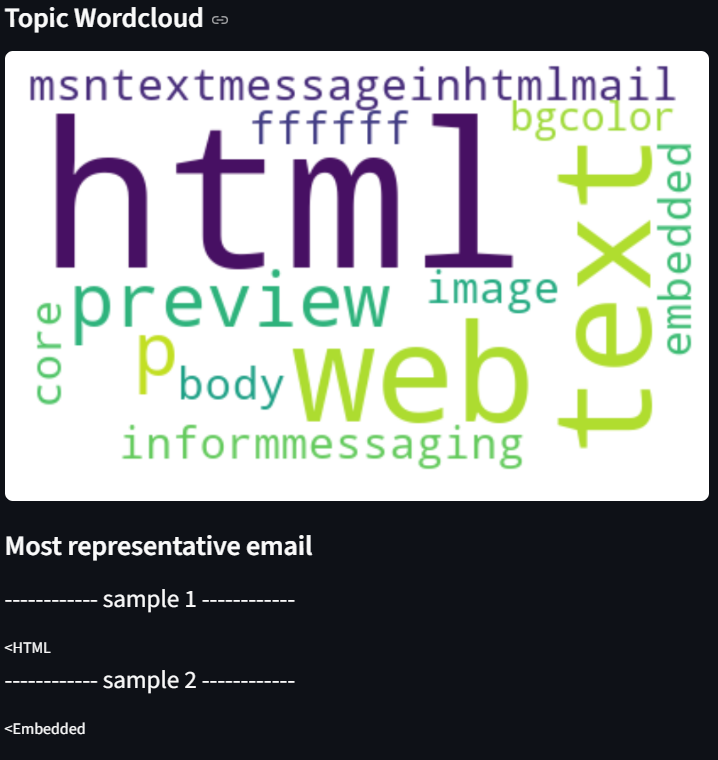|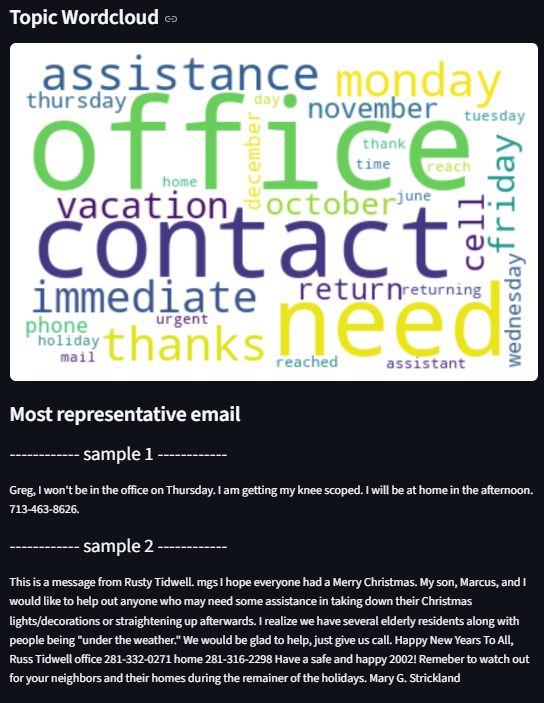|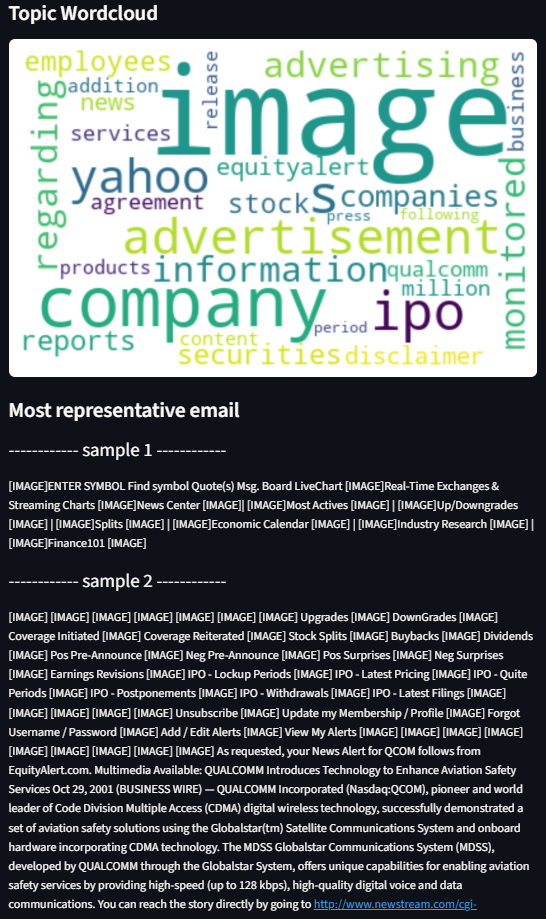|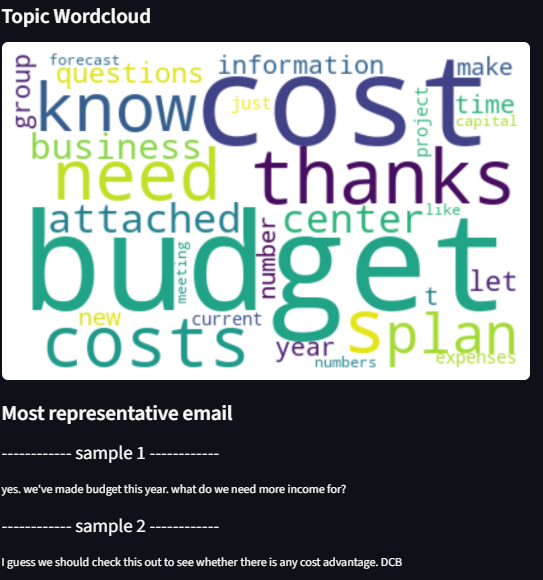|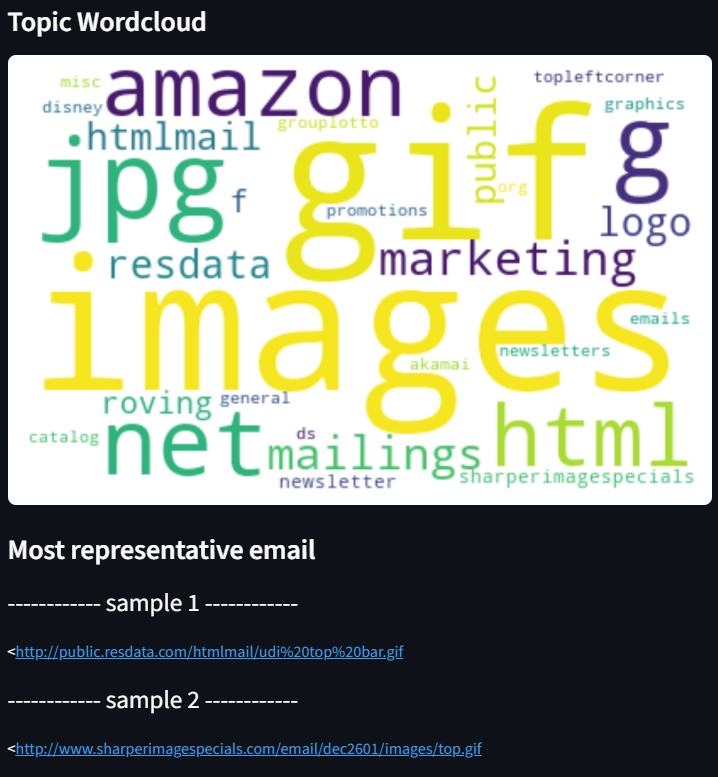|
|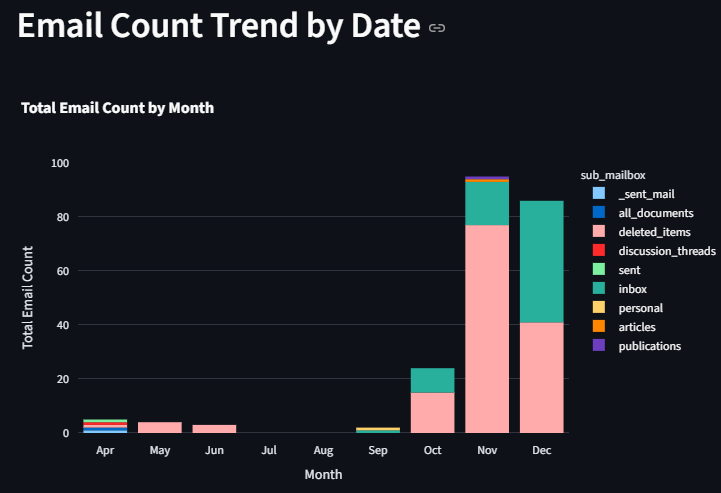|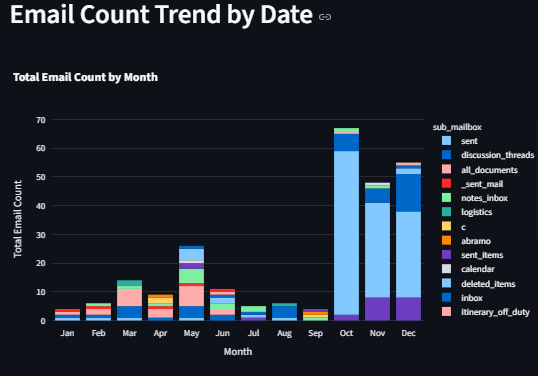|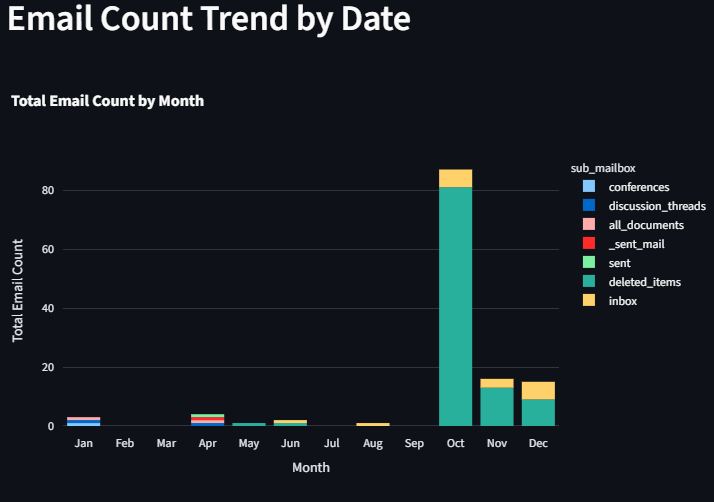|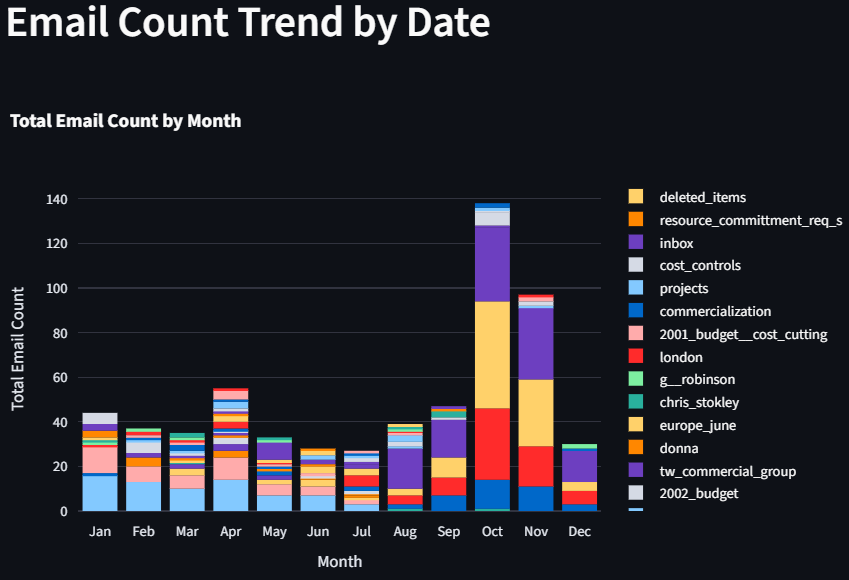|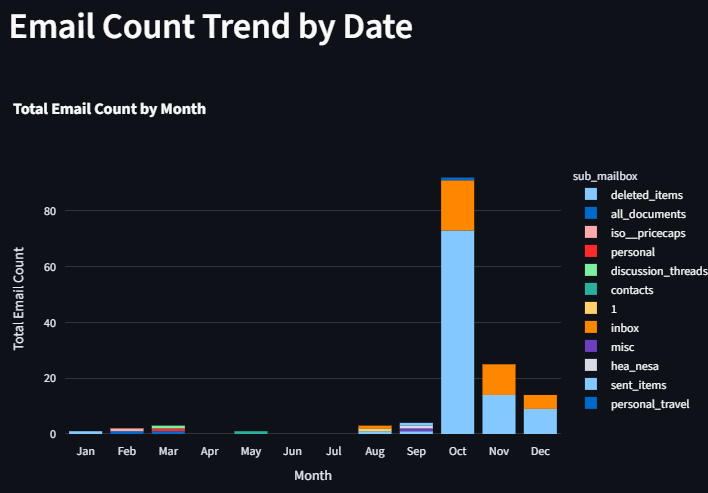|

## Top Topic Deleted Items (May June)

There was a small spike of deleted emails in May and June 2001. We are investigating what topics are these


In [21]:
df_clean_2001_pick_box.date_short_month.unique()

array(['May', 'Apr', 'Mar', 'Feb', 'Jan', 'Dec', 'Sep', 'Oct', 'Nov',
       'Jun', 'Jul', 'Aug'], dtype=object)

In [8]:
cond1=df_clean_2001_pick_box.hdbscan_clusters_roberta >-1
cond2=df_clean_2001_pick_box.sub_mailbox=='deleted_items'
cond3=df_clean_2001_pick_box.date_short_month.isin (['May','Jun'])

top_deleted = df_clean_2001_pick_box[cond1 & cond2 & cond3 & cond_wordLen].groupby('hdbscan_clusters_roberta').size().reset_index(name='email_count_deleted')#.sort_values(by='email_count', ascending=False)#.head(50)
top_deleted.set_index('hdbscan_clusters_roberta',inplace=True)
# 1. Calculate the total number of emails across all clusters (excluding noise -1)
total_emails_deleted = top_deleted['email_count_deleted'].sum()

# 2. Add a new column for the percentage share
# Divide the 'email_count' of each row by the total_emails
top_deleted['share_percent_deleted'] = (top_deleted['email_count_deleted'] / total_emails_deleted) * 100

# Optional: Format the percentage column to one decimal place for cleaner display
top_deleted['share_percent_deleted'] = top_deleted['share_percent_deleted']#.round(1)#.astype(str) + '%'


top_deleted = pd.merge(left=top_deleted,right=top_overall,on='hdbscan_clusters_roberta',how='inner')

top_deleted['deleted_%_fromTopic'] = 100*top_deleted['email_count_deleted']/top_deleted['email_count']
top_deleted['deleted_vs_overall_position'] = top_deleted['share_percent_deleted']/top_deleted['share_percent']

# top_deleted=top_deleted.sort_values(by='deleted_%_fromTopic', ascending=False)
top_deleted=top_deleted.sort_values(by='email_count_deleted', ascending=False)
# top_deleted=top_deleted.sort_values(by='deleted_vs_overall_position', ascending=False)
# Top topics 
top_deleted.head(5)



email_count_deleted  share_percent_deleted  \
hdbscan_clusters_roberta                                               
3784                                       62               2.306548   
3800                                       37               1.376488   
67                                         37               1.376488   
4                                          36               1.339286   
181                                        31               1.153274   

                          email_count  share_percent  deleted_%_fromTopic  \
hdbscan_clusters_roberta                                                    
3784                              128       0.106746            48.437500   
3800                               82       0.068384            45.121951   
67                                 80       0.066716            46.250000   
4                                 181       0.150945            19.889503   
181                                37       0.030856            83.783784   

                          deleted_vs_overall_position  
hdbscan_clusters_roberta                               
3784                                        21.607846  
3800                                        20.128788  
67                                          20.632008  
4                                            8.872657  
181                                         37.375734

## Top 5 Deleted Topics in May and June from HDBSCAN Clusters

By using topic dashboard we got the following info to describe these clusters

1. Cluster 3784 - investment / stock related emails
2. Clutser 3800 - investment / stock related emails
3. Cluster 67 - some track event / sponsorship by enron happened in JUNE
4. Cluster 4 - Concerning power / energy cost and demand forecast
5. Cluster 181 - French emails from BNP paribas


| Cluster 3784 | Cluster 3800 | Cluster 67 | Cluster 4 | Cluster 181 |
|---|---|---|---|---|
|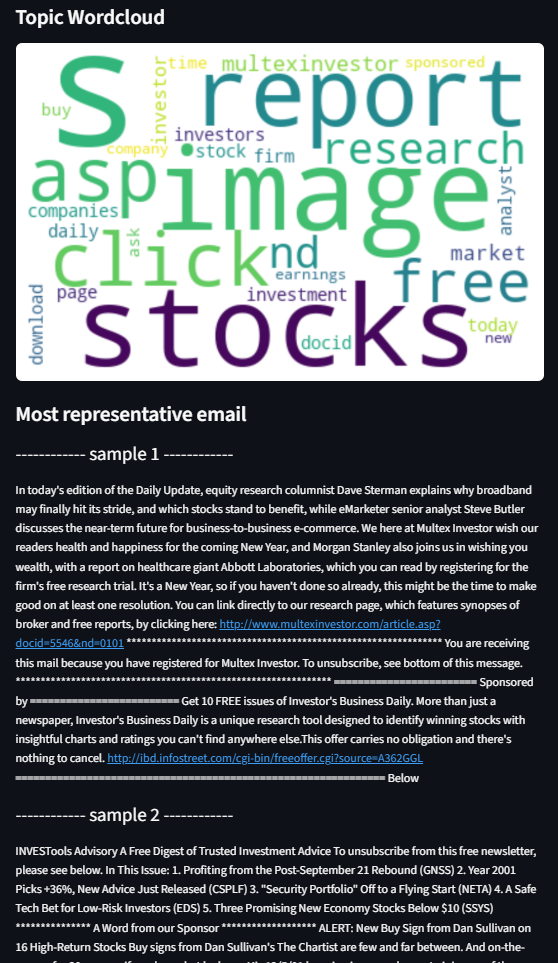|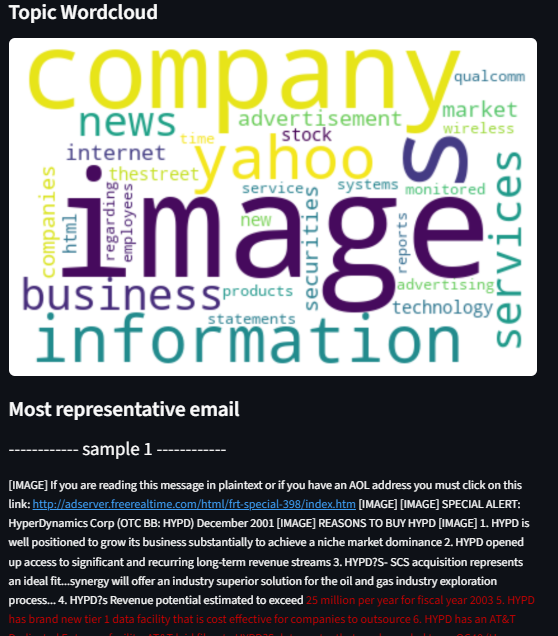|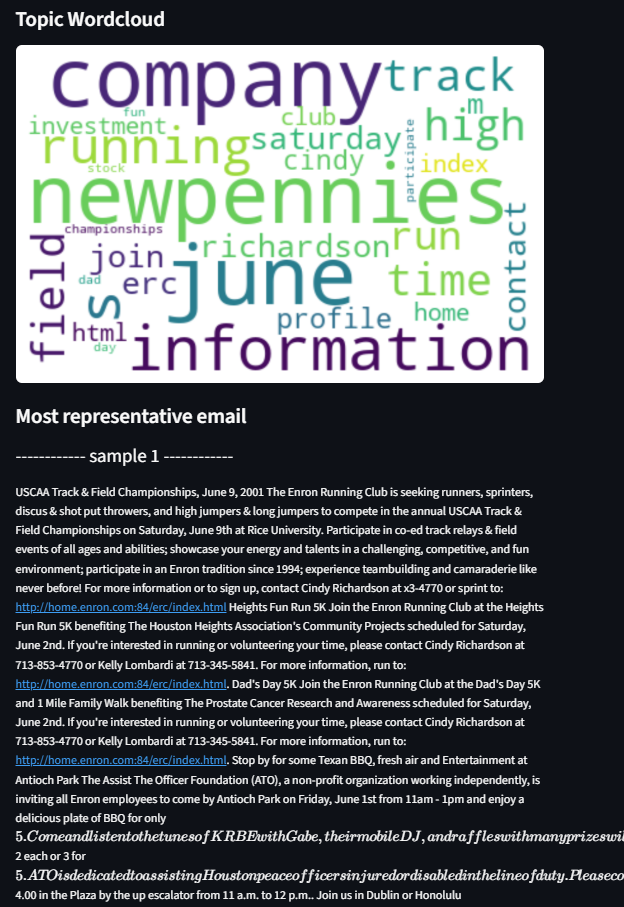|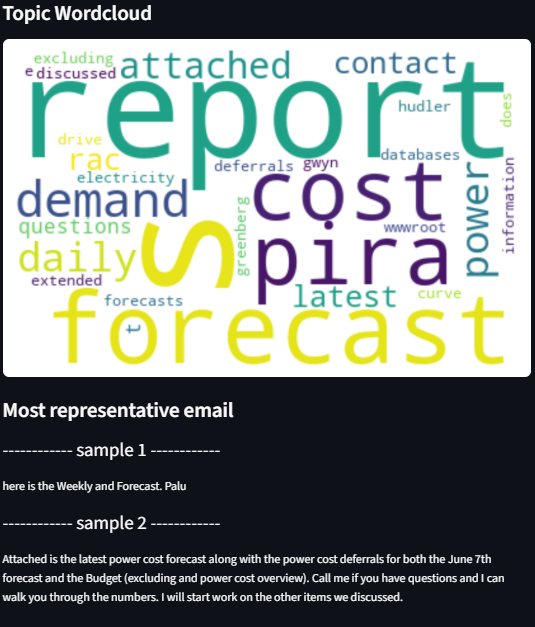|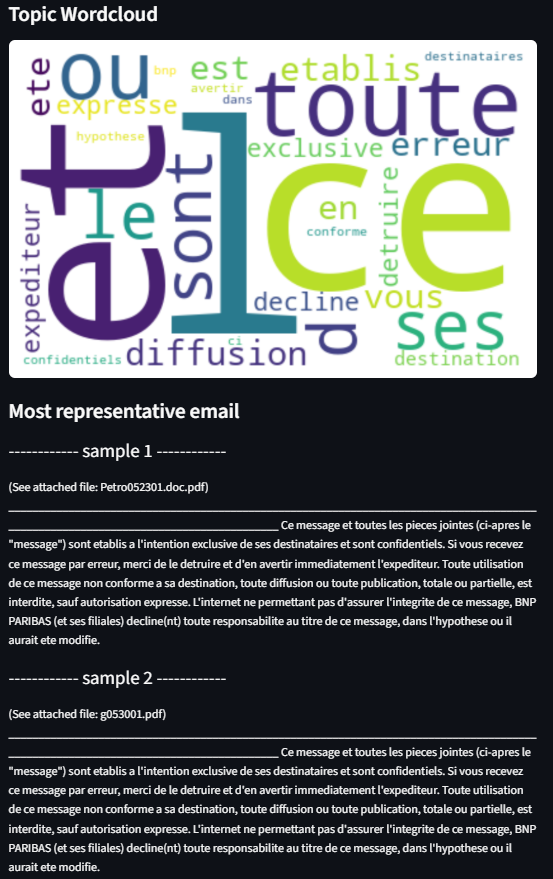|
|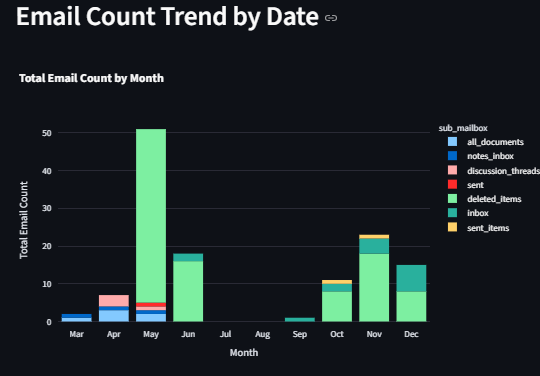|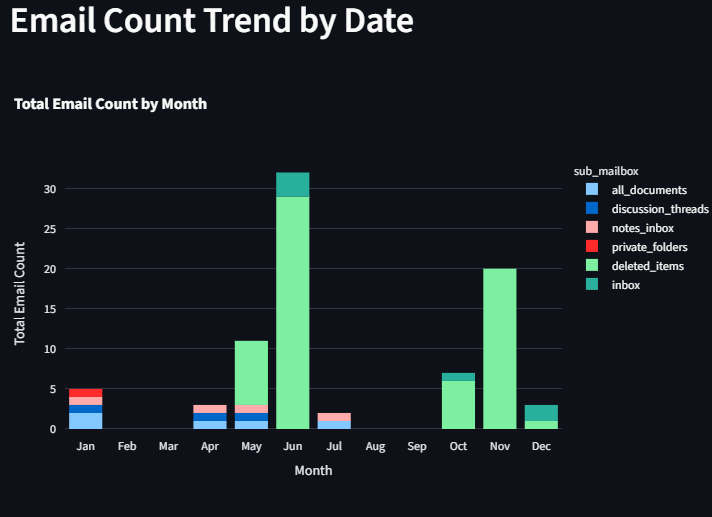|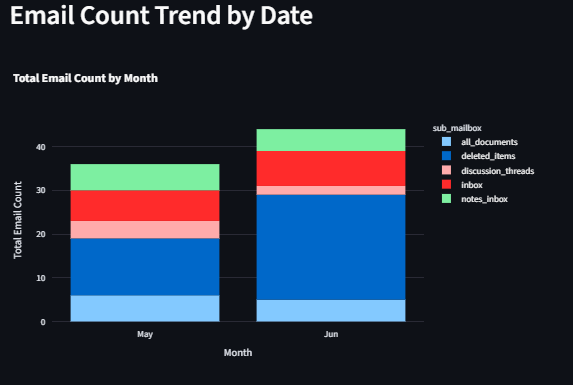|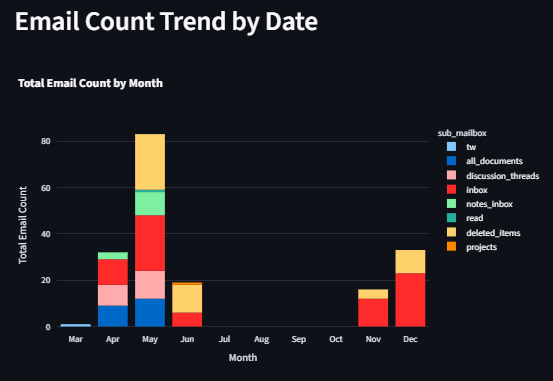|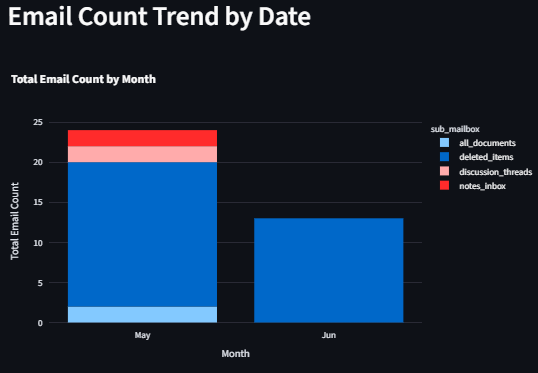|

## Top Topic found in Ken Lay's Mailbox (Enron Chairman)

As a key figure in ENRON, We looked into Ken Lay's email as a point of interest

In [ ]:
cond1=df_clean_2001_pick.hdbscan_clusters_roberta >-1
cond2=df_clean_2001_pick.person_box.isin(['LAY-K','Lay-K'])


top_topic_ken = df_clean_2001_pick[cond1 & cond2 & cond_wordLen].groupby('hdbscan_clusters_roberta').size().reset_index(name='email_count_ken')#.sort_values(by='email_count', ascending=False)#.head(50)

#Get total emails of ken
total_emails_ken = top_topic_ken['email_count_ken'].sum()
top_topic_ken.set_index('hdbscan_clusters_roberta',inplace=True)


# 2. Add a new column for the percentage share
# Divide the 'email_count' of each row by the total_emails
top_topic_ken['share_percent_ken'] = (top_topic_ken['email_count_ken'] / total_emails_ken) * 100

# Optional: Format the percentage column to one decimal place for cleaner display
top_topic_ken['share_percent_ken'] = top_topic_ken['share_percent_ken']#.round(1)#.astype(str) + '%'


top_topic_ken = pd.merge(left=top_topic_ken,right=top_overall,on='hdbscan_clusters_roberta',how='inner')

top_topic_ken['ken_%_fromTopic'] = 100*top_topic_ken['email_count_ken']/top_topic_ken['email_count']

# top_topic_ken=top_topic_ken.sort_values(by='ken_%_fromTopic', ascending=False)
top_topic_ken=top_topic_ken.sort_values(by='email_count_ken', ascending=False)
# Top topics 

top_topic_ken.head(5)




email_count_ken  share_percent_ken  email_count  \
hdbscan_clusters_roberta                                                    
3379                                  117          14.885496          161   
1527                                   21           2.671756           28   
3364                                   15           1.908397           37   
2125                                   13           1.653944           56   
1027                                   13           1.653944           84   

                          share_percent  ken_%_fromTopic  
hdbscan_clusters_roberta                                  
3379                           0.134266        72.670807  
1527                           0.023351        75.000000  
3364                           0.030856        40.540541  
2125                           0.046701        23.214286  
1027                           0.070052        15.476190

## Top 5 Topics found in Ken Lay's mailbox

By using topic dashboard we got the following info to describe these clusters

1. Cluster 3379 - Some email of encouragment directed at Ken or other leadership
2. Clutser 1527 - Emails screening appointments (probably from a personal assistant)
3. Cluster 3364 -Hate or email expressing dissapointment towards ENRON leadership
4. Cluster 2125 - Consulting reports received by top management/ correspondece with consultants
5. Cluster 1027 - emails with just attachments


| Cluster 3379 | Cluster 1527 | Cluster 3364 | Cluster 2125 | Cluster 1027 |
|---|---|---|---|---|
|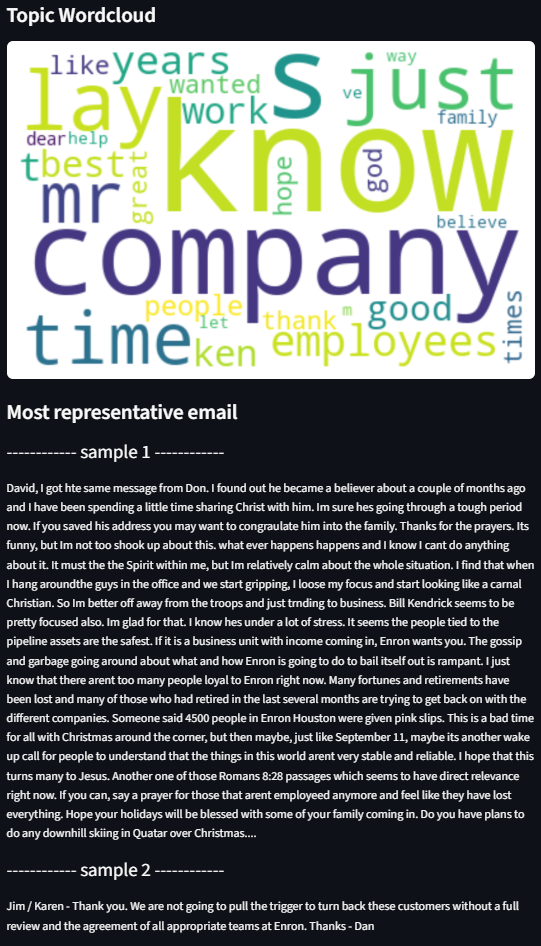|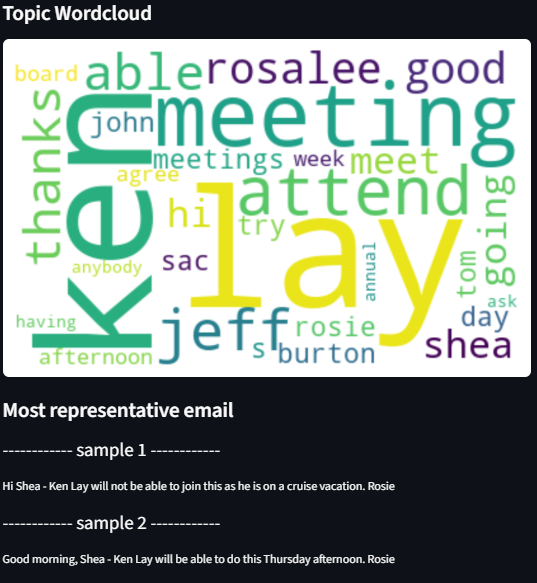|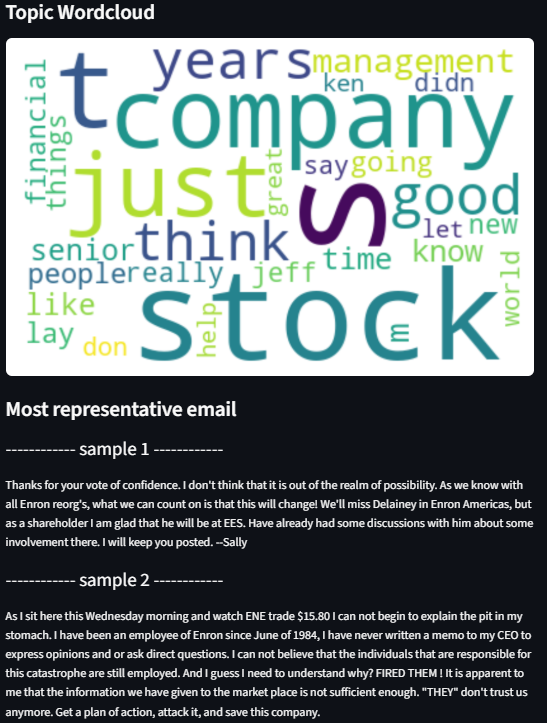|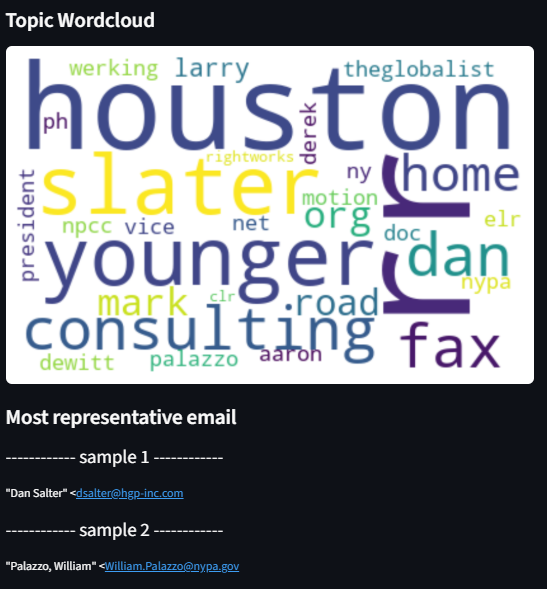|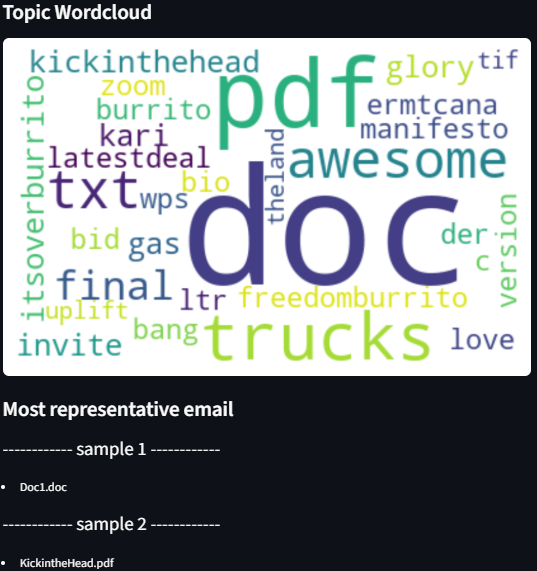|
|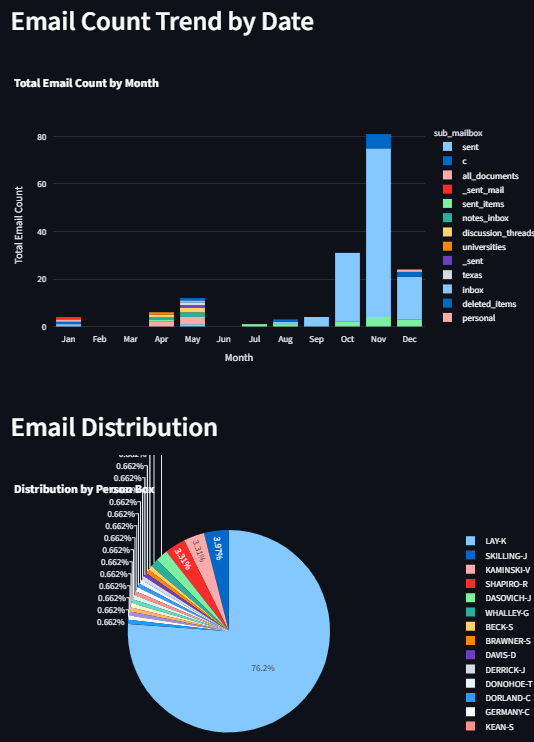|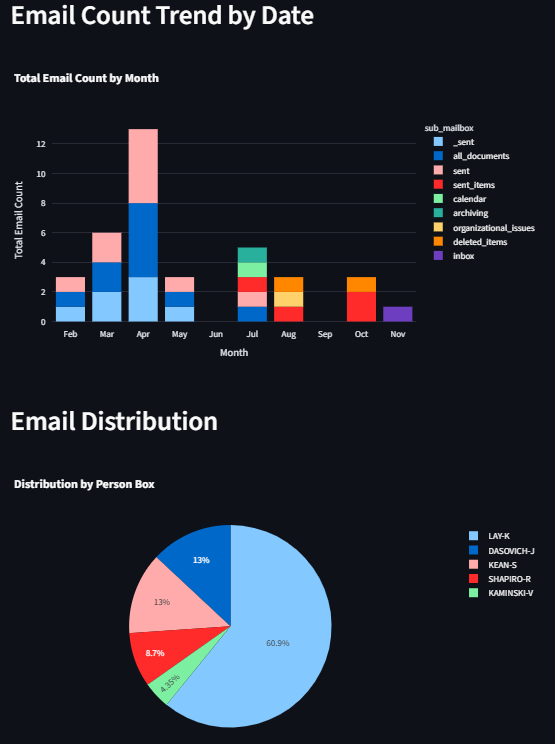|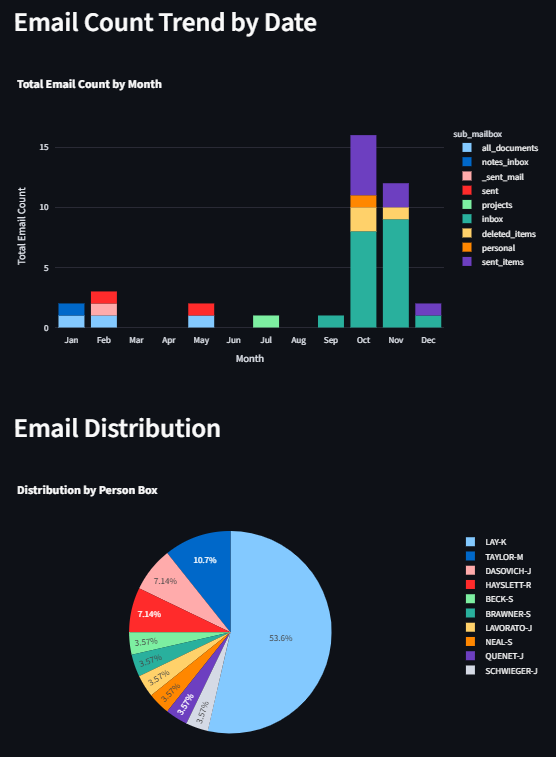|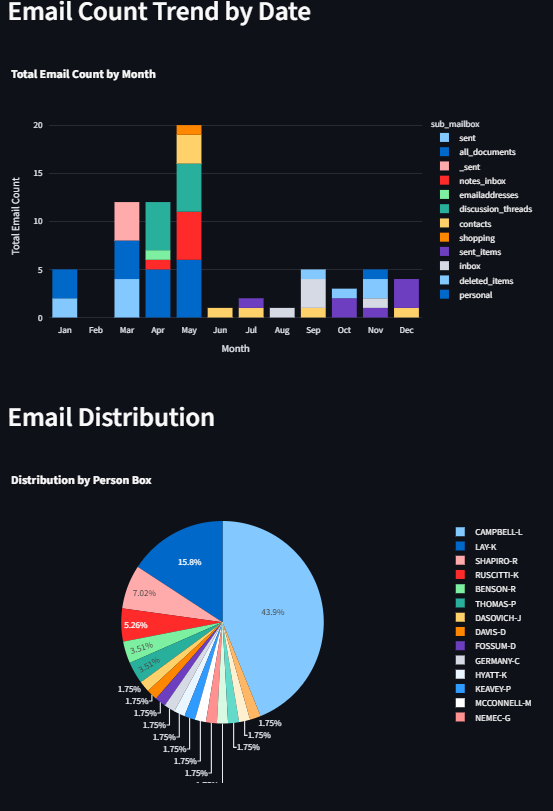|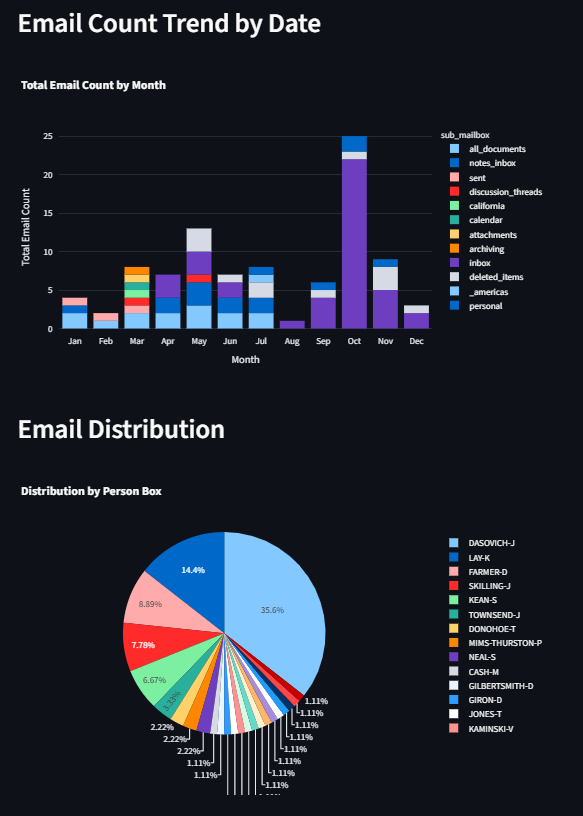|

## SUMMARY OF FINDINGS:

On spikes of emails deleted
- Deleted emails are those out of office/holidays, received from auto marketing emails, stock updates and those with embedded images and hyperlinks. Most probably spammy emails deleted when admin ask to free up mailbox space​
- Topic 3871, which talks about cost/budget and forecast, was among the top overall and deleted emails.
- Also, topic 3871 had a relatively higher deletion rate compared to other top topics​
- Cluster 3871 main recipients were Senior people like Louise Kitchen, Richard Shapiro and Sally Beck
- Without looking into the contents of the attachment, it will be hard to prove if the reason for deletion was due to remove evidence of accounting irregularities

On Ken Lay's Mailbox
- Top topics associated with Enron Chairman is what as expected, like his personal assistant screening appointments or letting people know he is not available.
- Consulting reports and emails that an executive normally receive​
- Interesting topics that emerged, especially in the last quarter of 2001 during Enron's challenging financial situation:​
    - Cluster 3379 – emails from sympathetic employees giving words of encouragement to top leadership​
    - Cluster 3364 – from angry / disappointed employees letting top management know how they felt​

    **Surprisingly even with the negative news on ENRON during that time, the positive email cluster still outnumbered the negative one**

